In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations
import networkx as nx
from scipy.sparse import csr_matrix
from math import log

import sys
sys.path.append("..")

In [2]:
df = pd.read_csv("../data/raw/recipes_by_ingredients.csv", index_col = 0)
#df = df.astype(bool)
df

,achiote paste,achiote powder,acini di pepe,acorn squash,active dry yeast,adobo sauce,adobo seasoning,adzuki beans,agave nectar,agave tequila,...,yellow rock sugar,yellow squash,yellow summer squash,yellow tomato,yellowfin tuna,yogurt cheese,yucca root,yukon gold potatoes,yuzu juice,zucchini blossoms
label,,,,,,,,,,,,,,,,,,,,,
Infineon Raceway Baked Beans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sour Cream Noodle Bake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Middle-Eastern Eggplant Rounds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Saffron Jewel Rice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thai Sweet and Sour Wings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spicy Agave Wave,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Apple Chimichangas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Summer Corn Salad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Creating an adjacency matrix for ingredient co-occurrence

# Creating a sparse matrix represenation of the data
X = csr_matrix(df.values)
ingredients = df.columns.to_list()
n_recipes = X.shape[0]

# Creating the co-occurrence matrix
cooccurrence = X.T @ X
cooccurrence.setdiag(0)
cooccurrence.eliminate_zeros()

# Number of recipes each ingredient appears in (as a flattened 1D array)
counts = X.sum(axis=0).A1

# Building the graph using PMI weights
G = nx.Graph()

coo = cooccurrence.tocoo()

for i, j, count in zip(coo.row, coo.col, coo.data):
    
    # TODO consider pruning out nodes that have less than a count threshold
    #if weight >= 5:
    #    G.add_edge(ingredients[i], ingredients[j], weight = weight)
    
    p_ij = count / n_recipes
    p_i = counts[i] / n_recipes
    p_j = counts[j] / n_recipes
    
    if p_ij > 0 and p_i > 0 and p_j > 0:
        pmi = max(0, log(p_ij / (p_i * p_j)))
        
        if pmi > 0:
            G.add_edge(ingredients[i], ingredients[j], weight = pmi)

In [43]:
G['chopped parsley']

AtlasView({'achiote paste': {'weight': 1.8527610938764765}, 'allspice berries': {'weight': 0.3923587606028639}, 'anchovy fillets': {'weight': 0.3401730074322938}, 'andouille sausage': {'weight': 1.8274432858921863}, 'angel hair': {'weight': 2.2776442878417424}, 'applewood smoked bacon': {'weight': 0.7041383846337053}, 'arborio rice': {'weight': 0.7041383846337053}, 'artichoke hearts': {'weight': 0.8135722256791676}, 'artisan bread': {'weight': 3.0314160902181224}, 'asparagus tips': {'weight': 2.338268909658177}, 'baby artichokes': {'weight': 1.584497107281797}, 'baby carrots': {'weight': 0.848177754856643}, 'baby greens': {'weight': 0.5465094404301222}, 'baby zucchini': {'weight': 3.0314160902181224}, 'bacon bits': {'weight': 1.8527610938764765}, 'baked beans': {'weight': 1.1988346264698124}, 'baked ham': {'weight': 2.4252802866478067}, 'balsamic vinegar': {'weight': 0.6492691743878911}, 'banana peppers': {'weight': 1.421978177784022}, 'basil leaves': {'weight': 1.7980712075798562}, 'b

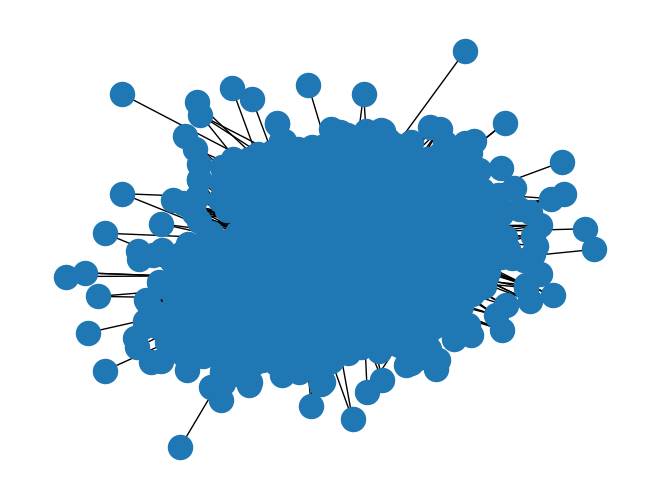

In [42]:
nx.draw(G, pos=nx.spring_layout(G))

In [44]:
from community import community_louvain

communities = community_louvain.best_partition(
    G,
    weight="weight",
    resolution=1.0
)

In [45]:
nx.set_node_attributes(G, communities, "community")

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 'community'

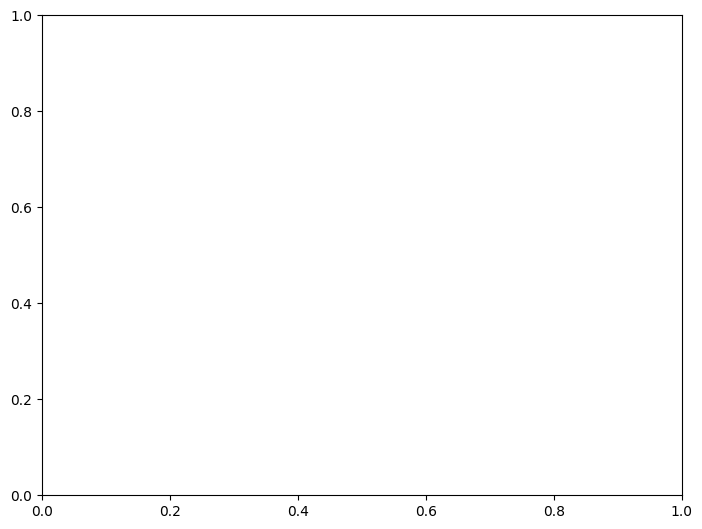

In [46]:
nx.draw(G, node_color='community')

In [4]:
def graph_recommendation(G, ingredient: str):
    return G[ingredient]

In [7]:
graph_recommendation(G, 'tomato paste')

AtlasView({'achiote powder': {'weight': 1.4600518217999972}, 'adobo sauce': {'weight': 1.1723697493482161}, 'adobo seasoning': {'weight': 1.4600518217999972}, 'almond flour': {'weight': 0.25607901747406125}, 'anchovy filets': {'weight': 2.270982038016326}, 'anchovy fillets': {'weight': 0.6783512438986069}, 'andouille sausage': {'weight': 0.6615441255822258}, 'andouille sausage links': {'weight': 3.6572763991362165}, 'angel hair': {'weight': 0.1309158745200553}, 'apple cider vinegar': {'weight': 0.847204583641695}, 'applewood smoked bacon': {'weight': 0.6368515129918543}, 'arborio rice': {'weight': 1.0423166211000183}, 'baby back ribs': {'weight': 0.9946885721107639}, 'baby corn': {'weight': 0.7669046412400519}, 'baby kale': {'weight': 0.43840057426801593}, 'baby potatoes': {'weight': 1.517210235639946}, 'baby spinach': {'weight': 0.3093235319928734}, 'baby spinach leaves': {'weight': 0.25607901747406125}, 'bacon drippings': {'weight': 1.354691306142171}, 'bacon fat': {'weight': 0.61275

In [5]:
recs = {}

for n, nbrs in G['tomato paste'].items():
    if n not in recs:
        recs[n] = nbrs['weight']

recs = dict(sorted(recs.items(), key=lambda item: -item[1]))
print(recs)

{'andouille sausage links': 3.6572763991362165, 'beef shin': 3.6572763991362165, 'cabbage head': 3.6572763991362165, 'creole seasoning': 3.6572763991362165, 'dark chicken stock': 3.6572763991362165, 'empanada dough': 3.6572763991362165, 'grated kefalotiri': 3.6572763991362165, 'gravy master': 3.6572763991362165, 'ground tumeric': 3.6572763991362165, 'hard cheese': 3.6572763991362165, 'lamb cubes': 3.6572763991362165, 'meat stock': 3.6572763991362165, 'meat-filled tortellini': 3.6572763991362165, 'paneer cheese': 3.6572763991362165, 'pareve margarine': 3.6572763991362165, 'rice pilaf': 3.6572763991362165, 'sea bream': 3.6572763991362165, 'shrimp powder': 3.6572763991362165, 'sliced chorizo': 3.6572763991362165, 'small red beans': 3.6572763991362165, 'tandoori paste': 3.6572763991362165, 'veal bones': 3.6572763991362165, 'unsalted beef stock': 3.6572763991362165, 'veal knuckle': 3.6572763991362165, 'dried pappardelle': 3.2518112910280523, 'turkey sausage links': 3.187272769890481, 'pappa

In [ ]:
def raw_count_recommendation(df: pd.DataFrame, ingredien: str):
    
    